# Introduction
Springleaf Financial Services aims to empower individuals with personal and auto loans. Direct mail marketing is a key strategy for reaching potential customers who might benefit from their services.

The goal of this project is to predict which customers will respond to direct mail offers using a large set of anonymized features. By constructing new meta-variables and applying feature-selection methods, we aim to build a model that maximizes the area under the ROC curve (AUC-ROC) for the predictions. This will help Springleaf enhance the effectiveness of their marketing efforts by focusing on customers who are most likely to respond.

Visit the Kaggle competition page for more information: https://www.kaggle.com/c/springleaf-marketing-response

### Step 1: Import Libraries

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

### Step 2: Load Dataset

In [2]:
dtype_spec = {8: 'str', 9: 'str', 10: 'str', 11: 'str', 12: 'str', 43: 'str', 196: 'str', 214: 'str', 225: 'str', 228: 'str', 229: 'str', 231: 'str', 235: 'str', 238: 'str'}
train_df = pd.read_csv("data/train_1000.csv", dtype=dtype_spec, low_memory=False).set_index('ID')
submission_df = pd.read_csv("data/test_1000.csv", dtype=dtype_spec, low_memory=False).set_index('ID')
target = train_df.pop('target')

train_idx = train_df.index
submission_idx = submission_df.index

df = pd.concat([train_df, submission_df])

df.head(3)

,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,...,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,Unnamed: 1931,Unnamed: 1932,VAR_1113,VAR_1114,VAR_1115
ID,,,,,,,,,,,,,,,,,,,,,
2,H,224,0,4300,C,0,0,False,False,False,...,998,999999998,998,998,9998,9998.0,IAPS,NaN,NaN,NaN
4,H,7,53,4448,B,1,0,False,False,False,...,998,999999998,998,998,9998,9998.0,IAPS,NaN,NaN,NaN
5,H,116,3,3464,C,0,0,False,False,False,...,998,999999998,998,998,9998,9998.0,IAPS,NaN,NaN,NaN


### Step 3: Basic Data Analysis

#### Descriptive Statistics

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VAR_0002,2000.0,107.9140,150.695807,0.0,23.75,60.0,132.25,999.0
VAR_0003,2000.0,89.2430,122.288242,0.0,14.00,60.0,122.00,999.0
VAR_0004,2000.0,3666.6490,8967.309700,0.0,1778.00,2500.0,3511.25,290200.0
VAR_0006,2000.0,0.6785,1.719481,0.0,0.00,0.0,1.00,24.0
VAR_0007,2000.0,0.4990,1.789581,0.0,0.00,0.0,1.00,66.0
...,...,...,...,...,...,...,...,...
VAR_1933,2000.0,4947.3015,4552.958091,0.0,998.00,998.0,9998.00,9999.0
Unnamed: 1931,1000.0,8924.7560,3085.977117,5.0,9998.00,9998.0,9998.00,9999.0
VAR_1113,1000.0,472.0560,454.218480,0.0,88.00,100.0,994.00,999.0
VAR_1114,1000.0,224.2300,349.220031,0.0,51.00,84.0,101.00,999.0


#### Data Inventory

In [4]:
print("Data Info Summary:")
print(df.info())

Data Info Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 2 to 2047
Columns: 1935 entries, VAR_0001 to VAR_1115
dtypes: float64(294), int64(1589), object(52)
memory usage: 29.5+ MB
None


#### Check for missing values

In [5]:
missing_values = df.isnull().sum()
missing_summary = missing_values[missing_values > 0].sort_values(ascending=False)
print(f"\nColumns with missing values (Total {missing_summary.shape[0]}):")
print(missing_summary.head(10))  # Display only the top 20 columns with missing values


Columns with missing values (Total 321):
VAR_0840    2000
VAR_0207    2000
VAR_0214    2000
VAR_0213    2000
VAR_0157    1986
VAR_0205    1975
VAR_0206    1972
VAR_0158    1967
VAR_0167    1961
VAR_0177    1949
dtype: int64


#### Number of colum per type

In [6]:
print(f"\nNumber of column per type:")
print(df.dtypes.value_counts())


Number of column per type:
int64      1589
float64     294
object       52
Name: count, dtype: int64


#### Check for duplicates

In [7]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

def find_duplicate_columns(df):
    duplicate_column_names = []
    for col in df.columns:
        if df.columns.duplicated().any():
            duplicate_column_names.append(col)
    return duplicate_column_names

duplicate_columns = find_duplicate_columns(df)
print(f"Duplicate columns: {duplicate_columns}")

Duplicate rows: 0
Duplicate columns: []


### Step 4: Data Cleaning and Preprocessing

#### Remove duplicate columns and rows

In [8]:
# Remove duplicate columns
df = df.loc[:,~df.columns.duplicated()]

# Remove duplicate rows
df = df.drop_duplicates()

#### Process numerical variables

In [9]:
def prep_numeric(df, train_idx, test_idx):
    initial_shape = df.shape

    # Remove features with only a single value
    num_unique = df.apply(lambda x: x.nunique())
    df = df[num_unique[num_unique > 1].index]
    shape_single_value_removal = df.shape

    # Remove features with all missing values
    num_missing = df.apply(lambda x: x.isnull().sum())
    df = df[num_missing[num_missing < df.shape[0]].index]
    shape_missing_value_removal = df.shape

    # Dropping columns that have high correlation to another
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    df = df.drop(to_drop, axis=1)
    shape_correlation_removal = df.shape

    # Dropping columns that have low variance
    var_thres = VarianceThreshold(threshold=0.1)
    var_thres.fit(df)
    constant_columns = [column for column in df.columns if column not in df.columns[var_thres.get_support()]]
    df = df.drop(constant_columns, axis=1)
    shape_variance_removal = df.shape

    # Split into train/test
    train = df.loc[train_idx]
    test = df.loc[test_idx]

    # Filling missing values with zero
    train = train.fillna(0)
    test = test.fillna(0)

    # Scaling the data
    scaler = StandardScaler()
    train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)
    test = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

    # Summary print
    print("\nSummary of dimension changes:")
    print(f"Initial shape: {initial_shape}")
    print(f"Single value removal: dropped {initial_shape[1] - shape_single_value_removal[1]} columns.")
    print(f"Missing value removal: dropped {shape_single_value_removal[1] - shape_missing_value_removal[1]} columns.")
    print(f"Correlation removal: dropped {shape_missing_value_removal[1] - shape_correlation_removal[1]} columns.")
    print(f"Variance removal: dropped {shape_correlation_removal[1] - shape_variance_removal[1]} columns.")

    return train, test

In [10]:
def prep_categorical(df, train_idx, test_idx):
    var_types = {
        'useful': [1, 5, 226, 232, 283, 305, 325, 352, 353, 354, 466, 467, 1934], # Handful of categories, with a mix of frequencies
        'useless': [8, 9, 10, 11, 12, 43, 44, 196, 200, 202, 214, 216, 222, 229, 230, 237, 239, 274, 342, 404], # No dicernable difference in outcome
        'dates': [73, 75, 156, 157, 158, 159, 166, 167, 168, 169, 176, 177, 178, 179, 204, 217] # Date
    }

    for key, val in var_types.items():
        var_types[key] = ['VAR_%04d' % v for v in val]

    df = df.drop(columns=var_types['useless'])

    def convert_dates(date_col):
        return pd.to_datetime(date_col, format='%d%b%y:%H:%M:%S', errors='coerce')

    def convert_all_date_columns(df):
        return df[var_types['dates']].apply(convert_dates)

    date_df = convert_all_date_columns(df)

    def engineer_dates(df):
        # Create a DataFrame to hold the date differences
        diff_df = pd.DataFrame({f'{col1}-{col2}': (df[col1] - df[col2]).dt.total_seconds().fillna(0).astype(int) for col1 in df for col2 in df if col1 < col2})

        # Summary statistics for the dates
        summary_df = df.agg(['max', 'min']).T
        summary_df['num_missing'] = df.isnull().sum(axis=1)
        summary_df['date_range'] = (summary_df['max'] - summary_df['min']).dt.total_seconds().fillna(0).astype(int)

        # Convert all to integer after filling NaNs
        summary_df = summary_df.fillna(0).astype({'max': 'int64', 'min': 'int64', 'num_missing': 'int64', 'date_range': 'int64'})

        return pd.concat([summary_df, diff_df], axis=1).fillna(0).astype(int)

    eng_date_df = engineer_dates(date_df)

    train_df = df.loc[train_idx]
    submission_df = df.loc[test_idx]

    class CategoryEncoder:
        def __init__(self):
            self.encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

        def fit(self, df):
            self.encoder.fit(df)

        def transform(self, df):
            return pd.DataFrame(self.encoder.transform(df), index=df.index, columns=self.encoder.get_feature_names_out(df.columns))

    enc = CategoryEncoder()
    enc.fit(train_df[var_types['useful']])
    ohe_train = enc.transform(train_df[var_types['useful']])
    ohe_submission = enc.transform(submission_df[var_types['useful']])

    train_df = pd.concat([eng_date_df.loc[train_idx], ohe_train], axis=1)
    submission_df = pd.concat([eng_date_df.loc[test_idx], ohe_submission], axis=1)

    return train_df, submission_df

In [11]:
# Process numeric
dtypes = df.dtypes
numeric_vars = df.loc[:, (dtypes=='int64') | (dtypes=='float64')]
num_train, num_submission = prep_numeric(numeric_vars, train_idx, submission_idx)


Summary of dimension changes:
Initial shape: (2000, 1883)
Single value removal: dropped 63 columns.
Missing value removal: dropped 0 columns.
Correlation removal: dropped 858 columns.
Variance removal: dropped 131 columns.


In [12]:
# Process categorical
df['target'] = 0
df.target[train_df.index] = target
cat_train, cat_submission = prep_categorical(df, train_idx, submission_idx)

In [13]:
X = pd.concat([num_train, cat_train], axis=1)
X_submission = pd.concat([num_submission, cat_submission], axis=1)
y = target

In [14]:
df_cleaned = pd.concat([X, y], axis=1)
df_cleaned.to_csv("data/cleaned_train.csv", index=False)
X_submission.to_csv("data/cleaned_test.csv", index=False)

### Step 5: Exploratory Data Analysis (EDA)

#### Target Variable Distribution

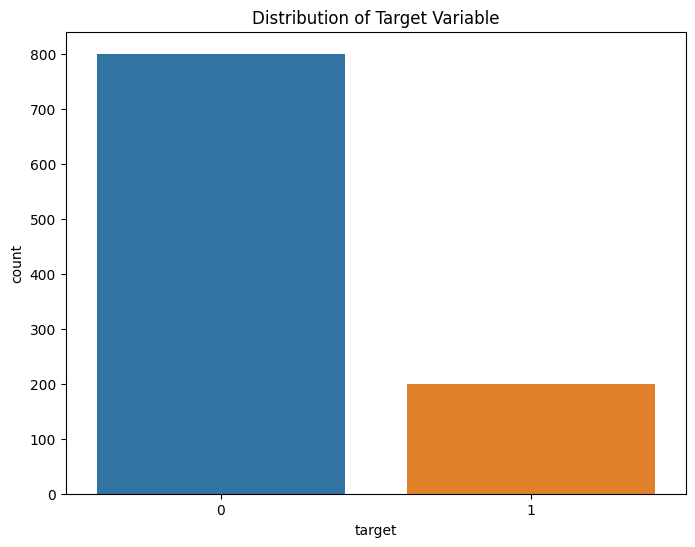

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_cleaned)
plt.title('Distribution of Target Variable')
plt.show()

#### Correlation Analysis

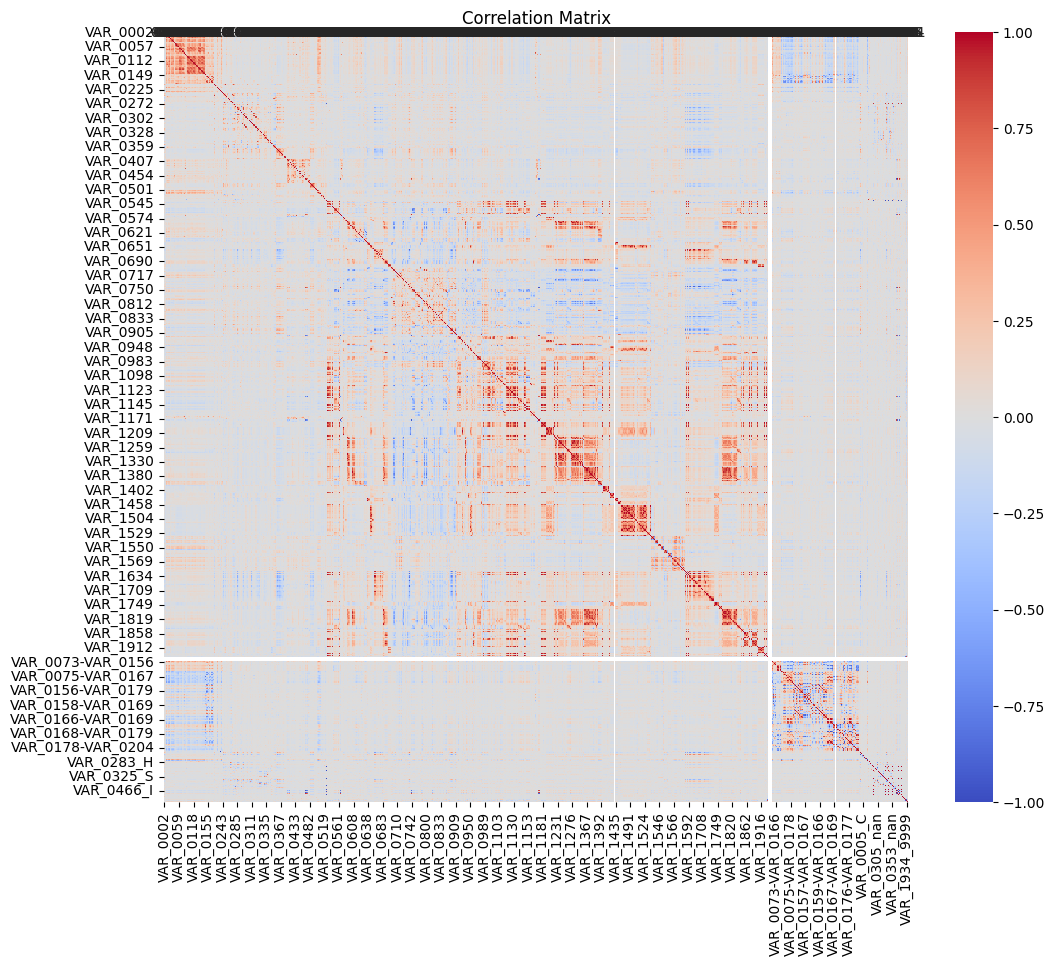

In [15]:
# Computing correlation matrix
cor_matrix = df_cleaned.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# Step 6: Model Selection and Training with ROC AUC Optimization

### Define models and parameters

In [ ]:
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


params = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_features': ['sqrt'],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'min_samples_split': [2, 5, 10]
    },
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'XGBoost': {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
    }
}

### Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Perform hyperparameter tuning and model evaluation

In [ ]:
best_models = {}
for model_name in models:
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(models[model_name], params[model_name], cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

Training RandomForest...
Training GradientBoosting...
Training LogisticRegression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Training KNeighbors...
Training XGBoost...


# Step 7: Evaluation

##### Evaluate the best models on the test set and collect results

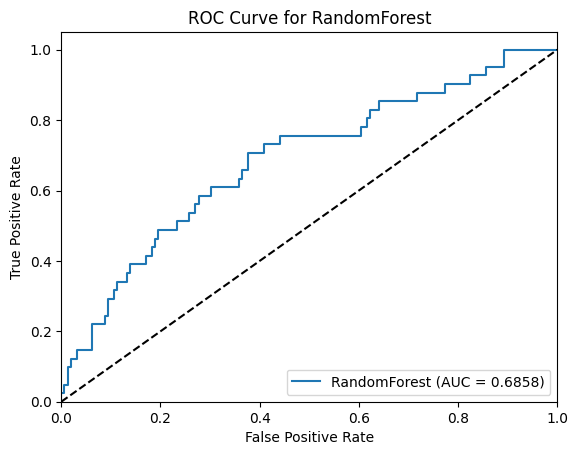

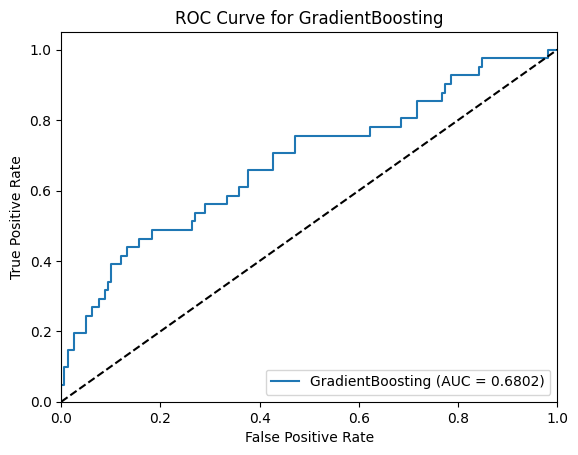

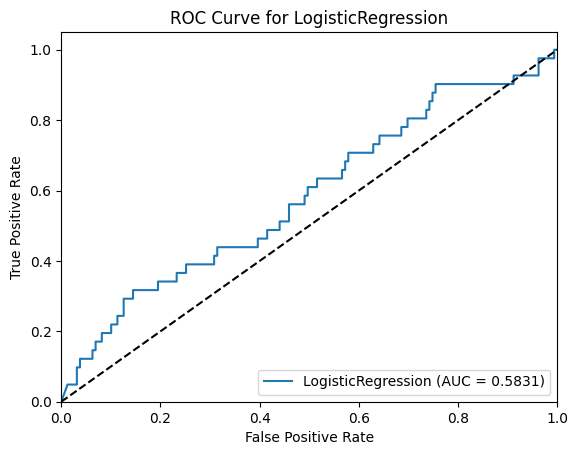

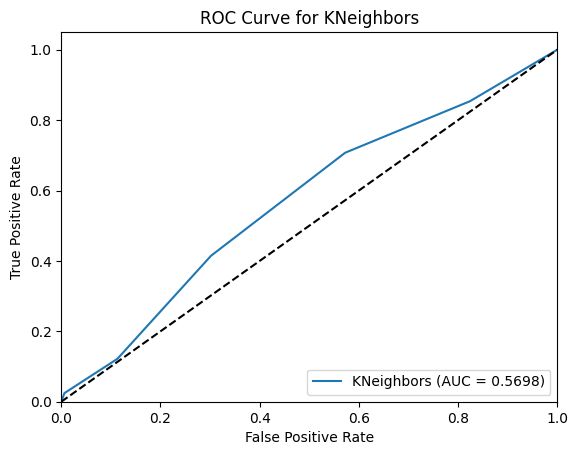

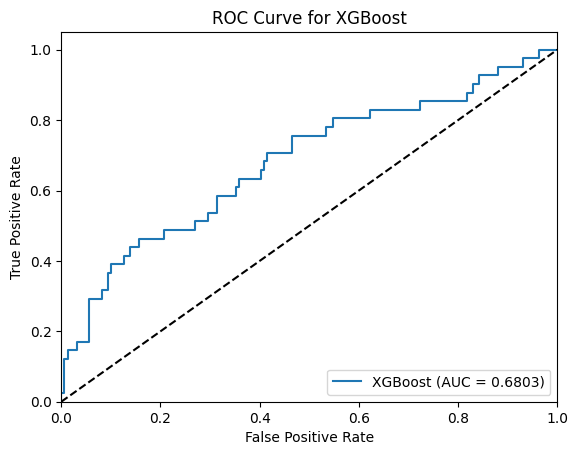

In [ ]:
metrics_list = []
for model_name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    metrics = {
        'Model': model_name,
        'ROC AUC': roc_auc,
        'Classification Report': classification_report(y_test, model.predict(X_test), output_dict=True)
    }
    metrics_list.append(metrics)

#### Create a DataFrame to display the ROC AUC results

In [ ]:
roc_auc_df = pd.DataFrame(metrics_list).drop(columns='Classification Report')
roc_auc_df

,Model,ROC AUC
0,RandomForest,0.685841
1,GradientBoosting,0.680166
2,LogisticRegression,0.583065
3,KNeighbors,0.569796
4,XGBoost,0.680319


#### Display the full classification report for the best model

In [ ]:
best_model_name = max(metrics_list, key=lambda x: x['ROC AUC'])['Model']
best_model_report = next(item for item in metrics_list if item['Model'] == best_model_name)['Classification Report']
print(f"Classification Report for the Best Model ({best_model_name}):")
pd.DataFrame(best_model_report).T

Classification Report for the Best Model (RandomForest):


,precision,recall,f1-score,support
0,0.808290,0.981132,0.886364,159.0
1,0.571429,0.097561,0.166667,41.0
accuracy,0.800000,0.800000,0.800000,0.8
macro avg,0.689859,0.539347,0.526515,200.0
weighted avg,0.759734,0.800000,0.738826,200.0


The RandomForest model performed best with an ROC AUC score of 0.685841, effectively identifying 0 class but with lower precision and recall for 1 class. This model can help Springleaf Financial Services improve their direct mail marketing by targeting individuals more likely to respond, thus enhancing marketing efficiency. Future efforts could focus on further tuning and exploring additional features to boost performance.

# Step 8: Make Predictions on the Test Set

In [ ]:
best_model = best_models[best_model_name]
submission_pred_proba = best_model.predict_proba(X_submission)[:, 1]

# Prepare the submission DataFrame
submission = pd.DataFrame({
    'ID': submission_idx,
    'target': submission_pred_proba
})

# Save the submission file
submission.to_csv('data/submission.csv', index=False)

print("Predictions saved to data/submission.csv")

Predictions saved to submission.csv
